In [1]:
!pip install datasets
from datasets import load_dataset

In [2]:
!pip install timm
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.11/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.11/index.html


In [3]:
import numpy as np
import cv2
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import yaml

In [5]:
parent_path = "drive/MyDrive/M202A/"
# Make edit in the cloned repo so that it reads the pretrained file from Google Drive directory

In [6]:
!git clone https://github.com/yikaiw/TokenFusion

fatal: destination path 'TokenFusion' already exists and is not an empty directory.


In [7]:
from TokenFusion.semantic_segmentation.models.segformer import *

/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


Hyperparameter Setup and other banal things

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
Segmodel = WeTr('mit_b1',num_classes=40)
Segmodel.eval()
Segmodel.to(device)
pass

Importing Data into Disk

In [10]:
from datasets import load_from_disk
ds = load_from_disk(parent_path+"NYU/")


Loading Testing Dataset

In [11]:
path_to_dataset = "drive//MyDrive//M202A//nyu_depth_v2_labeled.mat"

def extract_files(config):
  path = config["path"]
  f = h5py.File(path_to_dataset)
  length = len(f["images"])
  indices = np.random.randint(0,length,size=length//3)
  batch_size = length//3
  color = np.zeros((batch_size,480,640,3))
  rawdepth = np.zeros((batch_size,480,640))
  truedepth = np.zeros_like(rawdepth)
  for i in tqdm(range(0,len(indices))):
    j = indices[i]
    # read 0-th image. original format is [3 x 640 x 480], uint8
    img = f['images'][j].astype(np.uint8)
    img = img.transpose(2,1,0)
    color[i,...] = img
    rawD = f['rawDepths'][j]
    rawdepth[i,...] = rawD.T.astype(np.float32)
    depth_from_disk = f["depths"][j].astype(np.float32)
    truedepth[i,...] = depth_from_disk.T
  config["color"] = color
  config["depth"] = truedepth
  config["rawDepth"] = rawdepth
config={"path":path_to_dataset}
extract_files(config)

100%|██████████| 483/483 [00:15<00:00, 31.09it/s]




```
# Loading Training Dataset from HuggingFace to PyTorch for easy training
```

In [12]:
rgb_config = {"R_u":-0.00776206,"R_w":0.01519309,"Rvar":6.88208756e-06,
              "G_u":0.01147944,"G_w":0.50978071,"Gvar":9.19419688e-06,
              "B_u":0.00371937,"B_w":0.47502621,"Bvar":6.89479643e-06}

# Depth Noise based on the Channels, readings taken @0.5m

In [13]:
print(len(ds['train']))
ds.set_format("torch", device=device)
ds.shuffle()

47584


DatasetDict({
    train: Dataset({
        features: ['image', 'depth_map'],
        num_rows: 47584
    })
    validation: Dataset({
        features: ['image', 'depth_map'],
        num_rows: 654
    })
})

Loading Pretrained Unet for Depth

In [14]:
with open(parent_path+'config.yaml', 'r') as file:
    model_configs = yaml.safe_load(file)
model_configs['model']['channels']=1
model_configs['model']['base filters']=16

In [15]:
from model import *

Loading the RGB Decoder from RDUNet

In [16]:
class Resnet_UNet(nn.Module):
  """
  Residual-Dense U-net for image denoising.
  """
  def __init__(self,**kwargs):
      super().__init__()
      channels = kwargs['channels']
      filters_0 = kwargs['base filters']
      filters_1 = 2 * filters_0
      filters_2 = 4 * filters_0
      filters_3 = 8 * filters_0

      # Encoder:
      # Level 0:
      self.drop = nn.Dropout(p=0.2)
      self.input_block = InputBlock(4, filters_0)
      self.block_0_0 = DenoisingBlock(filters_0, filters_0 // 2, filters_0)
      self.block_0_1 = DenoisingBlock(filters_0, filters_0 // 2, filters_0)
      self.down_0 = DownsampleBlock(filters_0, filters_1)

      # Level 1:
      self.block_1_0 = DenoisingBlock(filters_1, filters_1 // 2, filters_1)
      self.block_1_1 = DenoisingBlock(filters_1, filters_1 // 2, filters_1)
      self.down_1 = DownsampleBlock(filters_1, filters_2)

      # Level 2:
      self.block_2_0 = DenoisingBlock(filters_2, filters_2 // 2, filters_2)
      self.block_2_1 = DenoisingBlock(filters_2, filters_2 // 2, filters_2)
      self.down_2 = DownsampleBlock(filters_2, filters_3)

      # Level 3 (Bottleneck)
      self.block_3_0 = DenoisingBlock(filters_3, filters_3 // 2, filters_3)
      self.block_3_1 = DenoisingBlock(filters_3, filters_3 // 2, filters_3)

      # Decoder
      # Level 2:
      self.up_2 = UpsampleBlock(filters_3, filters_2, filters_2)
      self.block_2_2 = DenoisingBlock(filters_2, filters_2 // 2, filters_2)
      self.block_2_3 = DenoisingBlock(filters_2, filters_2 // 2, filters_2)

      # Level 1:
      self.up_1 = UpsampleBlock(filters_2, filters_1, filters_1)
      self.block_1_2 = DenoisingBlock(filters_1, filters_1 // 2, filters_1)
      self.block_1_3 = DenoisingBlock(filters_1, filters_1 // 2, filters_1)

      # Level 0:
      self.up_0 = UpsampleBlock(filters_1, filters_0, filters_0)
      self.block_0_2 = DenoisingBlock(filters_0, filters_0 // 2, filters_0)
      self.block_0_3 = DenoisingBlock(filters_0, filters_0 // 2, filters_0)

      self.output_block = OutputBlock(filters_0, channels)


  def forward(self, inputs):
      inputs = self.drop(inputs)
      out_0 = self.input_block(inputs)    # Level 0
      out_0 = self.block_0_0(out_0)
      out_0 = self.block_0_1(out_0)

      out_1 = self.down_0(out_0)          # Level 1
      out_1 = self.block_1_0(out_1)
      out_1 = self.block_1_1(out_1)

      out_2 = self.down_1(out_1)          # Level 2
      out_2 = self.block_2_0(out_2)
      out_2 = self.block_2_1(out_2)

      out_3 = self.down_2(out_2)          # Level 3 (Bottleneck)

      out_3 = self.block_3_0(out_3)
      out_3 = self.block_3_1(out_3)



      out_4 = self.up_2([out_3, out_2])   # Level 2
      out_4 = self.block_2_2(out_4)
      out_4 = self.block_2_3(out_4)

      out_5 = self.up_1([out_4, out_1])   # Level 1
      out_5 = self.block_1_2(out_5)
      out_5 = self.block_1_3(out_5)

      out_6 = self.up_0([out_5, out_0])   # Level 0
      out_6 = self.block_0_2(out_6)
      out_6 = self.block_0_3(out_6)

      return self.output_block(out_6)


Loading Optimizers, Schedulers and Training the network

In [17]:
train_data = ds['train']
val_data = ds['validation']

In [18]:
def add_noise_inloop(depth,cfg=rgb_config):
  R_noise  = cfg["Rvar"]*(torch.randn(depth.shape,device=device))+cfg["R_u"]
  G_noise  =cfg["Gvar"]*(torch.randn(depth.shape,device=device))+cfg["G_u"]
  B_noise  = cfg["Bvar"]*(torch.randn(depth.shape,device=device))+cfg["B_u"]
  noise = cfg["R_w"]*R_noise+cfg["G_w"]*G_noise+cfg["B_w"]*B_noise
  noise[:,1:,:,:] = 0
  depth = depth+noise
  return depth, noise[:,0,:,:].unsqueeze(1)

In [19]:
from tqdm import tqdm
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

```
Sanity Testing the Segmentaion Loss before plugging it into the loss model
```

In [20]:
ce_loss = nn.CrossEntropyLoss()
from torchvision import transforms
color_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
def customSegLoss(gt_d,pred_d,color):

  loss = 0
  gt_d = torch.hstack((gt_d,gt_d,gt_d))
  pred_d = torch.hstack((pred_d,pred_d,pred_d))
  color = color_transform(color)
  seginp_gt = [color,gt_d]
  seginp_pred = [color,pred_d]
  original,_  = Segmodel(seginp_gt)
  denoised,_ = Segmodel(seginp_pred)
  for i in range(len(original)):
    loss+= ce_loss(denoised[i],original[i])
  return loss

In [21]:
def test_loop():
  error = []
  color=config["color"]
  truedepth = config["depth"]
  rawdepth= config["rawDepth"]
  length = len(color)
  with torch.no_grad():
    for i in (range(length)):
      depth_img = torch.tensor(rawdepth[i],dtype=torch.float32).to(device).reshape(1,1,480,640)
      color_img  = torch.tensor(color[i],dtype=torch.float32).to(device).permute(2,0,1).unsqueeze(0)/255
      stacked = torch.hstack((depth_img,color_img))
      Z,n= add_noise_inloop(stacked,rgb_config)
      noise_estimate = ResUnet(Z)
      denoised_depth = (Z[:,0,:,:].unsqueeze(1) - n_estimate)
      mask =depth_img> 0
      masked_denoised_depth =denoised_depth*mask
      gt = truedepth[i]
      gt_tensor = torch.tensor(gt,dtype=torch.float).to(device)
      loss = (masked_denoised_depth-gt_tensor*mask).to("cpu").detach().numpy()
      error.append(loss)
    mae = [np.mean(abs(i)) for i in error]
    rmse = [np.sqrt(np.mean(i**2)) for i in error]
    print("Average mean squared error is ",np.mean(mae)*1000,"mm")
    print("Average root mean squared error is ",np.mean(rmse)*1000,"mm")

In [22]:
mse_loss = nn.MSELoss()
n_epochs = 5
lr = 1e-4
best_vloss = 1_000_000.
ResUnet = Resnet_UNet(**model_configs['model'])
ResUnet.to(device)
bs = 4
freq = bs * 200;
optimizer= torch.optim.AdamW(filter(lambda p:p.requires_grad,ResUnet.parameters()),lr=1e-3,weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
for epoch in (range(n_epochs)):
  train_data.shuffle()
  val_data.shuffle()

  running_loss = 0

  ## Training Loop
  for i in tqdm(range(0,len(train_data),bs)):
    with torch.autocast(device_type='cuda', dtype=torch.float16):
      optimizer.zero_grad()
      color = train_data[i:i+bs]['image'].permute(0,3,1,2)/255 ## Channels first and normalizing to 0 and 1
      depth = train_data[i:i+bs]['depth_map'].unsqueeze(0).permute(1,0,2,3)
      stacked = torch.hstack((depth,color))
      Z,n = add_noise_inloop(stacked,rgb_config)
      n_estimate = ResUnet(Z)
      denoised_depth_estimate = (Z[:,0,:,:].unsqueeze(1) - n_estimate)
      loss = mse_loss(denoised_depth_estimate,depth)
      loss.backward(retain_graph=True)

      loss = customSegLoss(depth,denoised_depth_estimate,color)
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
      if(i%freq==0 and i!=0):
        avg_loss = running_loss/freq
        running_loss = 0
        running_vloss = 0;
        with torch.no_grad():
          for count in range(len(val_data)):
            optimizer.zero_grad()
            color = train_data[i]['image'].permute(2,0,1).unsqueeze(0)/255 ## Channels first and normalizing to 0 and 1
            depth = train_data[i]['depth_map'].reshape(1,1,480,640)
            stacked = torch.hstack((depth,color))
            Z,n = add_noise_inloop(stacked,rgb_config)
            n_estimate = ResUnet(Z)
            denoised_depth_estimate = (Z[:,0,:,:].unsqueeze(1) - n_estimate)
            loss = mse_loss(depth,denoised_depth_estimate)
            running_vloss+=loss.item()
          avg_vloss = running_vloss/len(val_data)
          print("Loss train {} valid {}".format(avg_loss,avg_vloss))
          if avg_loss < best_vloss:
            best_vloss = avg_loss
            model_path = 'model_{}_{}'.format(timestamp, i)
            torch.save(ResUnet.state_dict(), parent_path+"SEGmodel_weights.pth")
        test_loop()
        scheduler.step()


  0%|          | 0/11896 [00:00<?, ?it/s]/content/TokenFusion/semantic_segmentation/models/segformer.py:121: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha_soft = F.softmax(self.alpha)
  2%|▏         | 200/11896 [04:34<4:19:47,  1.33s/it]

Loss train nan valid nan


  2%|▏         | 200/11896 [05:19<5:11:32,  1.60s/it]


KeyboardInterrupt: ignored

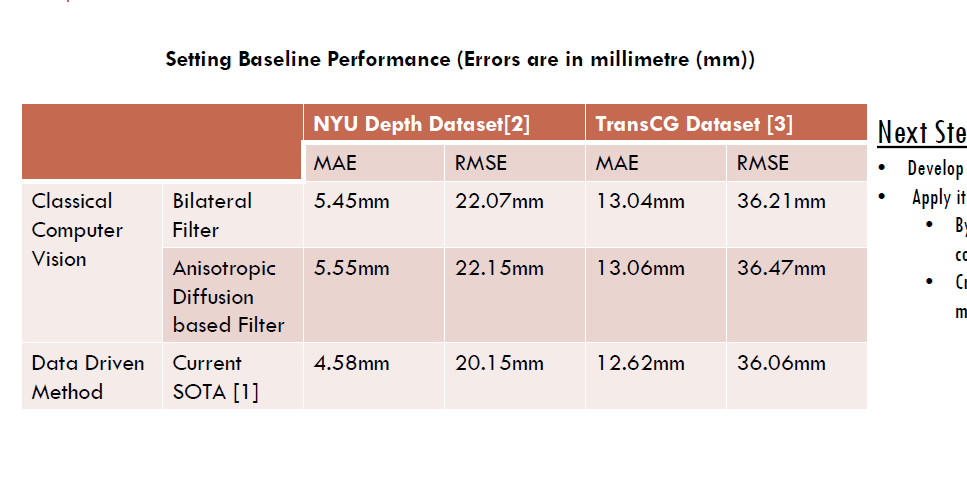

Eval

In [ ]:

error = []
color=config["color"]
truedepth = config["depth"]
rawdepth= config["rawDepth"]
length = len(color)
denoised_depth_images = np.zeros_like(color)
with torch.no_grad():
  for i in (range(length)):
    depth_img = torch.tensor(rawdepth[i],dtype=torch.float32).to(device).reshape(1,1,480,640)
    color_img  = torch.tensor(color[i],dtype=torch.float32).to(device).permute(2,0,1).unsqueeze(0)/255
    stacked = torch.hstack((depth_img,color_img))
    Z,n= add_noise_inloop(stacked,rgb_config)
    denoised_depth = ResUnet(Z)
    mask =depth_img> 0
    masked_denoised_depth =denoised_depth*mask
    gt = truedepth[i]
    gt_tensor = torch.tensor(gt,dtype=torch.float).to(device)
    loss = (masked_denoised_depth-gt_tensor*mask).to("cpu").detach().numpy()
    denoised_depth_images[i,...] = denoised_depth.detach().to("cpu").numpy()
    error.append(loss)
mae = [np.mean(abs(i)) for i in error]
rmse = [np.sqrt(np.mean(i**2)) for i in error]
print("Average mean squared error is ",np.mean(mae)*1000,"mm")
print("Average root mean squared error is ",np.mean(rmse)*1000,"mm")
random_indice = np.random.randint(low=0,high = len(mae),size=5)
denoised_images = denoised_depth_images[random_indice]
mean_squared_error = (truedepth[random_indice] - denoised_depth_images[random_indice])**2
fig,axs = plt.subplots(5,3)
for i in range(0,5):
      axs[i,0].imshow(truedepth[random_indice[i]],cmap="jet")
      axs[i,1].imshow(denoised_depth_images[random_indice[i]],cmap="jet")
      axs[i,2].imshow(mean_squared_error[i],cmap='jet') ## There will be a band of error on the borders, because of how the sensor was setup
plt.show()